In [1]:
using PotentialFlow

In [2]:
using Plots

# grid for evaluation
x = range(-4,4,length=401)
y = copy(x)
z = x .+ im*y';

# unit circle
θ = range(0,2π,length=101)
zc = exp.(im*θ[1:end-1]);

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


### A few helper routines

In [3]:
strength(v::Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}) = v.S
strength(v::Vector{T}) where {T<:PotentialFlow.Points.Point} = map(vj -> strength(vj),v) 

strength (generic function with 2 methods)

In [4]:
# Create a set of n random point vortices in the range [-2,2]x[-2,2], all of which are outside the unit circle
function create_random_vortices(n::Integer;σ=0.01)
    z = ComplexF64[]
    Γ = Float64[]
    num = 0
    while num < n
        ztest = 4.0(rand(ComplexF64)-0.5-im*0.5)
        Γtest = 2.0(rand(Float64)-0.5)
        if (abs2(ztest)>1.0)
            push!(z,ztest)
            push!(Γ,Γtest)
            num += 1
        end
    end
    return Vortex.Blob.(z,Γ,σ)
end

create_random_vortices (generic function with 1 method)

### Define the functions that comprise the pressure and its gradients

In [5]:
flag = 1
Fvd(z,zv) = -0.5im/π*log(z-zv)
Fvi(z,zv) = -flag*0.5im/π*(-log(z-1/conj(zv)) + log(z))
Fv(z,zv) = Fvd(z,zv) + Fvi(z,zv) 
wvd(z,zv;ϵ=0.01) = -0.5im/π*conj(z-zv)/(abs2(z-zv)+ϵ^2)
wvi(z,zv) = -flag*0.5im/π*(-1/(z-1/conj(zv)) + 1/z)
wv(z,zv;ϵ=0.01) = wvd(z,zv;ϵ=ϵ) + wvi(z,zv)

dwvddz(z,zv;ϵ=0.01) = 0.5im*conj(z-zv)^2/π/(abs2(z-zv) + ϵ^2)^2
dwvddzstar(z,zv;ϵ=0.01) = -0.5im*ϵ^2/π/(abs2(z-zv) + ϵ^2)^2
dwvidz(z,zv) = -flag*0.5im/π*(1/(z-1/conj(zv))^2-1/z^2)
dwvdz(z,zv;ϵ=0.01) = dwvddz(z,zv;ϵ=ϵ) + dwvidz(z,zv)
dwvddzv(z,zv;ϵ=0.01) = -dwvddz(z,zv;ϵ=ϵ)
dwvddzvstar(z,zv;ϵ=0.01) = -dwvddzstar(z,zv;ϵ=ϵ)
dwvidzvstar(z,zv) = -flag*0.5im/π/conj(zv)^2/(z-1/conj(zv))^2
dwvdzvstar(z,zv;ϵ=0.01) = dwvddzvstar(z,zv;ϵ=ϵ) + dwvidzvstar(z,zv)

dFddzv(z,zv;ϵ=0.01) = -wvd(z,zv;ϵ=ϵ)
dFidzvstar(z,zv) = flag*0.5im/π/conj(zv)^2/(z-1/conj(zv))
dFdzv(z,zv;ϵ=0.01) = dFddzv(z,zv;ϵ=0.01) + conj(dFidzvstar(z,zv))

d2Fddzv2(z,zv;ϵ=0.01) = -dwvddz(z,zv;ϵ=ϵ)
d2Fddzvdvzstar(z,zv;ϵ=0.01) = -dwvddzstar(z,zv;ϵ=ϵ)
d2Fidzvstar2(z,zv) = -flag*0.5im/π/conj(zv)^3/(z-1/conj(zv))*(2 + 1/conj(zv)/(z-1/conj(zv)))
d2Fdzv2(z,zv;ϵ=0.01) = d2Fddzv2(z,zv;ϵ=0.01) + conj(d2Fidzvstar2(z,zv))


P(z,zv;kwargs...) = -0.5*abs2(wv(z,zv;kwargs...)) - real(dFdzv(z,zv;kwargs...)*conj(wvi(zv,zv)))
Π(z,zvj,zvk;kwargs...) = -real(wv(z,zvj;kwargs...)*conj(wv(z,zvk;kwargs...))) -
                           real(dFdzv(z,zvj;kwargs...)*conj(wv(zvj,zvk;kwargs...))) -
                           real(dFdzv(z,zvk;kwargs...)*conj(wv(zvk,zvj;kwargs...)))

dPdzv(z,zv;kwargs...) = -0.5*(dwvddzv(z,zv;kwargs...)*conj(wv(z,zv;kwargs...)) + wv(z,zv;kwargs...)*conj(dwvdzvstar(z,zv;kwargs...))) -
                        0.5*(d2Fdzv2(z,zv;kwargs...)*conj(wvi(zv,zv)) + dFdzv(z,zv;kwargs...)*conj(dwvidzvstar(zv,zv))) -
                        0.5*(conj(dFdzv(z,zv;kwargs...))*dwvidz(zv,zv))

dΠdzvl(z,zvl,zvk;kwargs...) = -0.5*(dwvddzv(z,zvl;kwargs...)*conj(wv(z,zvk;kwargs...)) + conj(dwvddzvstar(z,zvl)+dwvidzvstar(z,zvl))*wv(z,zvk;kwargs...)) -
                               0.5*(d2Fdzv2(z,zvl;kwargs...)*conj(wv(zvl,zvk;kwargs...)) + dFdzv(z,zvl;kwargs...)*conj(dwvddzstar(zvl,zvk)) + conj(d2Fddzvdvzstar(z,zvl;kwargs...))*wvd(zvl,zvk;kwargs...)  + conj(dFdzv(z,zvl;kwargs...))*dwvdz(zvl,zvk;kwargs...)) -
                               0.5*(dFdzv(z,zvk;kwargs...)*conj(dwvdzvstar(zvk,zvl;kwargs...)) + conj(dFdzv(z,zvk;kwargs...))*dwvddzv(zvk,zvl;kwargs...))

dΠdzvl (generic function with 1 method)

### Define the complex potential and velocity

In [6]:
for f in [:F,:w]

    vd = Symbol(f,"vd")
    vi = Symbol(f,"vi")

    @eval function $f(z,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        out = complex(0)
        for vj in v
            zj = Elements.position(vj)
            out += strength(vj)*($vd(z,zj;kwargs...) + $vi(z,zj;kwargs...))
        end
        return out
    end
    
    @eval $f(z::AbstractArray,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> $f(zj,v;kwargs...),z)
end

# Rate of change of vortex positions
#dzvdt = conj.(w(Elements.position(vort),vort));

### Define the pressure and its gradients

Note that $\mathrm{d}p/\mathrm{d}z^* = (\mathrm{d}p/\mathrm{d}z)^*$. To obtain the gradient of pressure with respect to the $x$ or $y$ position of vortex $l$, use

$$\frac{\partial p}{\partial x_l} = \frac{\mathrm{d}p}{\mathrm{d}z_l} + \frac{\mathrm{d}p}{\mathrm{d}z^*_l} = 2 \mathrm{Re} \frac{\mathrm{d}p}{\mathrm{d}z_l}$$

and

$$\frac{\partial p}{\partial y_l} = \mathrm{i}\frac{\mathrm{d}p}{\mathrm{d}z_l} - \mathrm{i} \frac{\mathrm{d}p}{\mathrm{d}z^*_l} = -2 \mathrm{Im} \frac{\mathrm{d}p}{\mathrm{d}z_l}$$

In [7]:
function pressure(z,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        out = 0.0
        for (j,vj) in enumerate(v)
            zj,Γj  = Elements.position(vj), strength(vj)
            out += Γj^2*P(z,zj;kwargs...)
            for vk in v[1:j-1]
                zk,Γk  = Elements.position(vk), strength(vk)
                out += Γj*Γk*Π(z,zj,zk;kwargs...)
            end
        end
        return out
end

# Change of pressure with respect to change of strength of vortex l (specified by its index)
function dpdΓv(z,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        zl,Γl  = Elements.position(v[l]), strength(v[l]) 
        out = 2*Γl*P(z,zl;kwargs...)
        for (k,vk) in enumerate(v)
            k == l && continue
            zk,Γk  = Elements.position(vk), strength(vk)
            out += Γk*Π(z,zl,zk;kwargs...)
        end
        return out
end

# Change of pressure with respect to change of position of vortex l (specified by its index)
function dpdzv(z,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}}
        zl,Γl  = Elements.position(v[l]), strength(v[l]) 
        out = Γl*dPdzv(z,zl;kwargs...)
        for (k,vk) in enumerate(v)
            k == l && continue
            zk,Γk  = Elements.position(vk), strength(vk)
            out += Γk*dΠdzvl(z,zl,zk;kwargs...)
        end
        return Γl*out
end


pressure(z::AbstractArray,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> pressure(zj,v;kwargs...),z)
dpdzv(z::AbstractArray,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> dpdzv(zj,l,v;kwargs...),z)
dpdΓv(z::AbstractArray,l::Integer,v::Vector{T};kwargs...) where {T<:Union{PotentialFlow.Points.Point,PotentialFlow.Blobs.Blob}} = map(zj -> dpdΓv(zj,l,v;kwargs...),z)

dpdΓv (generic function with 2 methods)

### Examples

In [8]:
vort = create_random_vortices(4)

4-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.3504820508037216 - 0.041313573752083776im, 0.7345250702592585, 0.01)
 Vortex.Blob(0.6622251291308201 + 1.8703641158755175im, 0.23037837076495649, 0.01)
 Vortex.Blob(1.8643995061956087 - 1.193875612089693im, 0.45848816513066337, 0.01)
 Vortex.Blob(-1.5954708977602365 + 0.8330152756426106im, -0.3728446316588001, 0.01)

In [9]:
# Evaluate on the observation points z
ψ = imag.(F(z,vort));
p = pressure(z,vort);
dpdz1 = dpdzv(z,1,vort);
dpdΓ1 = dpdΓv(z,1,vort);
dpdz2 = dpdzv(z,2,vort);

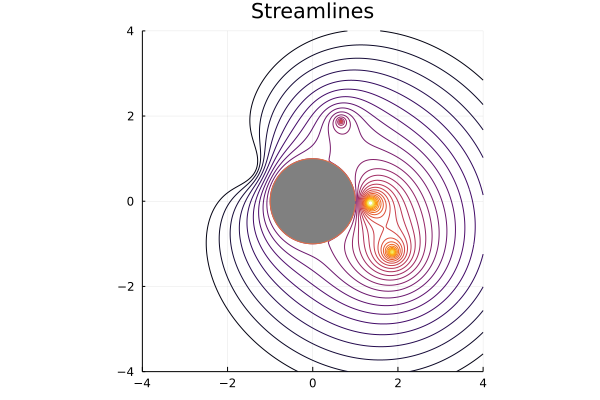

In [10]:
plot(x,y,ψ',ratio=1,levels=range(-0.25,0.25,length=31),clim=(-0.25,0.25))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="Streamlines")

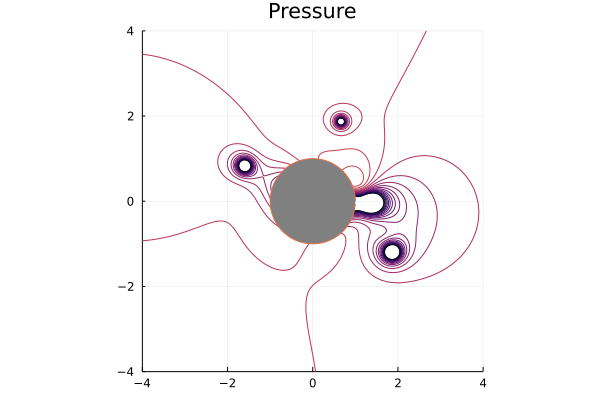

In [11]:
plot(x,y,p',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="Pressure")

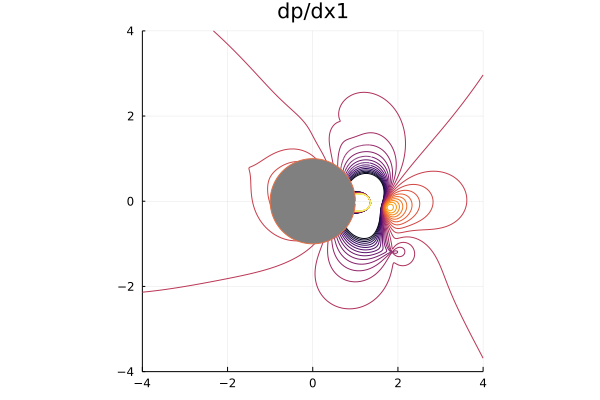

In [12]:
plot(x,y,2*real.(dpdz1)',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dx1")

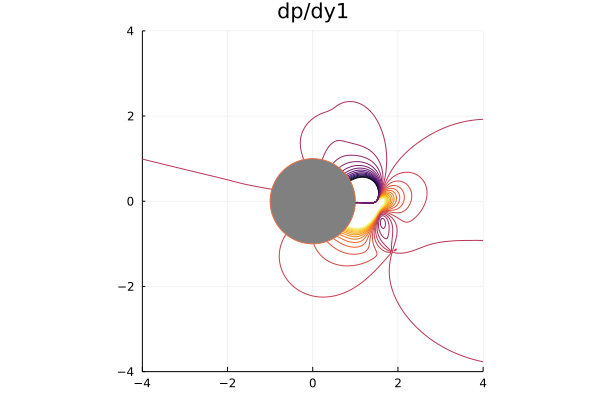

In [13]:
plot(x,y,-2*imag.(dpdz1)',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dy1")

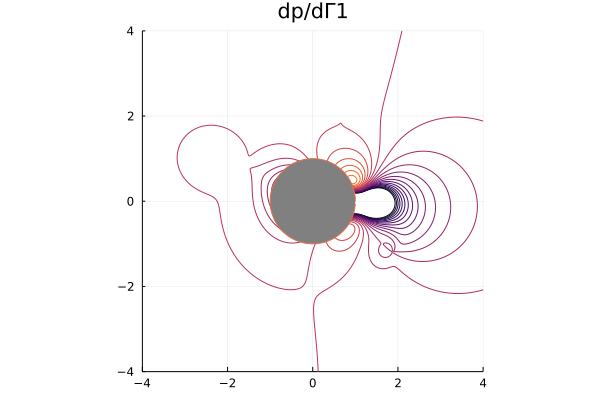

In [14]:
plot(x,y,dpdΓ1',ratio=1,levels=range(-0.1,0.1,length=31),clim=(-0.1,0.1))
plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
plot!(legend=false,colorbar=false,xlim=(-4,4),ylim=(-4,4),title="dp/dΓ1")

### Error calculation

In [20]:
using LinearAlgebra

In [27]:
# For verification purposes
zv = 1.5*[exp(im*π/2), exp(im*3π/2)];
Γv = [1.0,1.0];
vort = Vortex.Point.(zv,Γv)


# These below are only used for verification purposes
dx = sqrt(eps())#1e-4
vort_x1 = Vortex.Point.(zv .+ [dx,0],Γv)
vort_y1 = Vortex.Point.(zv .+ [im*dx,0],Γv)
vort_Γ1 = Vortex.Point.(zv,Γv.+[dx,0])

pc = pressure(zc,vort);
dpcdz1 = dpdzv(zc,1,vort);
dpcdΓ1 = dpdΓv(zc,1,vort);

pc_x1 = pressure(zc,vort_x1);
pc_y1 = pressure(zc,vort_y1);
pc_Γ1 = pressure(zc,vort_Γ1);

In [28]:
norm((1 / dx) * (pc_x1 - pc) - 2 * real.(dpcdz1)) / norm(2 * real.(dpcdz1))

0.0027890249964606954

In [29]:
norm((1 / dx) * (pc_y1 - pc) + 2 * imag.(dpcdz1)) / norm(2 * imag.(dpcdz1))

0.0024353229000962503

In [30]:
norm((1 / dx) * (pc_Γ1 - pc) - dpcdΓ1) / norm(dpcdΓ1)

6.958043127390548e-9